# Insights - Total population by year

## Introduction

This process is dependent on upstream processes. See the "Prerequisites" section below.

The workflow defined herein is identified as workflow ID #90 in the the [Data Team Master Document List](https://morpc1.sharepoint.com/:x:/s/GISteam/EfC4j3HhohZCrSZzxJdyt5cBFEqVD7zHick8ZW0INqgCYA?e=0WhrAI). References to document list identifiers are denoted by a number in brackets, e.g. [90].

## Process outline

  1. Load input dataset
  2. Extract required population facts
  3. Transform population facts to comply with output schema
  4. Export output dataset
  5. Create resource file

## Prerequisites and usage notes

  - Outputs of one or more upstream workflows must be available at the indicated paths. Make sure that those outputs are up to date prior to running this script. 
  - This script includes several intentional RuntimeError instances that may be triggered to alert the user to conditions that may require their attention. If the script triggers one of these errors, review the error, verify that the condition is acceptable or resolve any issues, then proceed.

## Setup

### Import required packages

In [82]:
import os
import shutil
import sys
import pandas as pd
import frictionless
sys.path.append(os.path.normpath("../morpc-common"))
import morpc
import morpcCensus

### User-specified parameters

In [2]:
MORPC_ESTIMATE_YEAR_RANGE = [2024, 2024]

MORPC_FORECAST_VINTAGE = 2023
MORPC_FORECAST_YEAR_RANGE = [2025, 2050]
MORPC_FORECAST_YEAR_INTERVAL = 5

DECENNIAL_YEAR_RANGE = [1980, 2020]
INTERCENSAL_YEAR_RANGE = [2000, 2010]

PEP_YEAR_RANGE = [INTERCENSAL_YEAR_RANGE[1]+1, MORPC_ESTIMATE_YEAR_RANGE[0]-1]

# When STALE_DATA_INTERRUPT == True, the script will produce a RuntimeError in certain situations where the input 
# data may be stale and updates might be required prior to running the script.  Otherwise, a warning will be generated 
# but script execution will continue.  Regardless of whether an error or warning occurs, be sure to verify the readiness 
# of all input data.
STALE_DATA_INTERRUPT = True

# If PRESERVE_INPUT_DATA == True, then the raw input data will be archived in the directory specified in INPUT_DIR
# Otherwise, the raw data will be deleted upon completion of the script.
PRESERVE_INPUT_DATA = True

# You can change where the input data is sourced and archived by changing the following directory and file names.  
# This typically is not necessary and may break other scripts that depend on outputs from this one. Source data 
# will be copied to this location.  Input data will be deleted following successful completion of the script 
# unless PRESERVE_INPUT_DATA == True.
INPUT_DIR = "./input_data"

# You can change where the output data is stored by changing the following directory and file names.  This 
# typically is not necessary and may break other scripts that depend on outputs from this one.
OUTPUT_DIR = "./output_data"

### Static parameters

### Define inputs

The following datasets are required by this notebook. They will be retrieved from the specified location and temporarily stored in INPUT_DIR. They will be deleted following successful completion of the script unless PRESERVE_INPUT_DATA == True.

#### Create input data directory

Create input data directory if it doesn't exist.

In [3]:
inputDir = os.path.normpath(INPUT_DIR)
if not os.path.exists(inputDir):
    os.makedirs(inputDir)

#### MORPC counties reference data [81]

Reference data for counties in the MORPC region will be loaded automatically as a morpc.countyLookup() object (see below).

#### MORPC combined population facts [286]

In [4]:
COMBINED_POP_FACTS_RESOURCE_PATH = "../morpc-pop-collect/output_data/morpc-pop-collect.resource.yaml"
print("Resource file: {}".format(COMBINED_POP_FACTS_RESOURCE_PATH))

Resource file: ../morpc-pop-collect/output_data/morpc-pop-collect.resource.yaml


### Define outputs

#### Create output data directory

Create output data directory if it doesn't exist.

In [5]:
outputDir = os.path.normpath(OUTPUT_DIR)
if not os.path.exists(outputDir):
    os.makedirs(outputDir)   

#### Insights total population by year [287]

In [6]:
INSIGHTS_POP_TABLE_FILENAME = "morpc-insights-pop-temporal.csv"
INSIGHTS_POP_TABLE_PATH = os.path.join(outputDir, INSIGHTS_POP_TABLE_FILENAME)
INSIGHTS_POP_TABLE_SCHEMA_PATH = INSIGHTS_POP_TABLE_PATH.replace(".csv",".schema.yaml")
INSIGHTS_POP_TABLE_RESOURCE_PATH = INSIGHTS_POP_TABLE_PATH.replace(".csv",".resource.yaml")
print("Data: {}".format(INSIGHTS_POP_TABLE_PATH))
print("Schema: {}".format(INSIGHTS_POP_TABLE_SCHEMA_PATH))
print("Resource file: {}".format(INSIGHTS_POP_TABLE_RESOURCE_PATH))

Data: output_data\morpc-insights-pop-temporal.csv
Schema: output_data\morpc-insights-pop-temporal.schema.yaml
Resource file: output_data\morpc-insights-pop-temporal.resource.yaml


## Prepare input data

### Load county reference data

In [7]:
countyLookup = morpc.countyLookup(scope="15-County Region")

Loading data for MORPC 15-County region only


### Combined population facts

In [139]:
(combinedPopRaw, combinedPopResource, combinedPopSchema) = morpc.frictionless_load_data(COMBINED_POP_FACTS_RESOURCE_PATH, archiveDir=inputDir, validate=True, verbose=True)

morpc.load_frictionless_data | INFO | Loading Frictionless Resource file at location ..\morpc-pop-collect\output_data\morpc-pop-collect.resource.yaml
morpc.load_frictionless_data | INFO | Copying data, resource file, and schema to directory input_data
morpc.load_frictionless_data | INFO | --> Data file: input_data\morpc-pop-collect.csv
morpc.load_frictionless_data | INFO | --> Resource file: input_data\morpc-pop-collect.resource.yaml
morpc.load_frictionless_data | INFO | --> Schema file: input_data\morpc-pop-collect.schema.yaml
morpc.load_frictionless_data | INFO | Validating resource including data and schema.

Validating resource on disk (including data and schema). This may take some time.
Resource is valid
morpc.load_frictionless_data | INFO | Loading data.
Casting field POP as type integer.
Casting field GEOID as type string.
Casting field SUMLEVEL as type string.
Casting field REFERENCE_PERIOD as type string.
Casting field REFERENCE_PERIOD_FREQ as type string.
Casting field VINTA

In [140]:
combinedPop = combinedPopRaw.copy()

In [141]:
combinedPop["GEO_TYPE"] = combinedPop["SUMLEVEL"].map(morpc.HIERARCHY_STRING_LOOKUP)

In [142]:
combinedPop = combinedPop.drop(columns=["SUMLEVEL","LAST_UPDATED"]) 

In [143]:
combinedPop.head()

,POP,GEOID,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE
0,111714,39041,2000,Y-JUN,2009,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY
1,223518,39041,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY
2,119098,39041,2001,Y-JUN,2009,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY
3,237292,39041,2001,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY
4,127011,39041,2002,Y-JUN,2009,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY


## Transform data

#### Load output schema

In [260]:
insightsPopSchema = morpc.frictionless_load_schema(INSIGHTS_POP_TABLE_SCHEMA_PATH)
insightsPopSchema

{'fields': [{'name': 'POP', 'type': 'integer', 'description': 'Population'},
            {'name': 'GEOID',
             'type': 'string',
             'description': 'Unique identifier for the geography as issued by '
                            'MORPC.  These are identical to Census-issued '
                            'GEOIDs for Census geographies.'},
            {'name': 'GEO_TYPE',
             'type': 'string',
             'description': 'Code which designates the summary level '
                            '(geography type) for which the GEOID applies.  '
                            'The combination of GEO_TYPE and GEOID uniquely '
                            'identify the geography for the record.'},
            {'name': 'DATE',
             'type': 'string',
             'description': 'ISO8601-compliant date string that identifies the '
                            'reference date for which the estimate applies'},
            {'name': 'VALUE_TYPE',
             'type': 'strin

### Create list to collect extracted data

In [261]:
extractedData = []

### Extract decennial census counts (NOT IMPLEMENTED)

### Extract intercensal estimates

Create list of years from user-specified range.

In [262]:
intercensalRange = list(range(INTERCENSAL_YEAR_RANGE[0], INTERCENSAL_YEAR_RANGE[1]+1))
print("Including intercensal estimates for years: {}".format(", ".join([str(x) for x in intercensalRange])))

Including intercensal estimates for years: 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010


Extract intercensal data from combined table.

In [263]:
intercensal = combinedPop.loc[combinedPop["SOURCE"] == "CENINT"].copy()

Reference period and vintage period were stored as strings, but for intercensal estimates we can treat them as integers. Convert them now.

In [264]:
intercensal = intercensal.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

Verify that data is available for the specified years.

In [265]:
if(not set(intercensalRange).issubset(set(intercensal["REFERENCE_PERIOD"]))):
    print("ERROR | Set of intercensal years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(INTERCENSAL_YEAR_RANGE))
    print("Specified set: {}".format(set(intercensalRange)))
    print("Available set: {}".format(set(intercensal["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | Intercensal data is available for all years in specified range.")

INFO | Intercensal data is available for all years in specified range.


Extract only the estimates for the specified years.

In [266]:
intercensal = morpc.extract_vintage(intercensal, refPeriods=intercensalRange)

Verify that all reference periods are present and that there is only a single vintage for each reference period.

In [267]:
for year in intercensal["REFERENCE_PERIOD"].unique():
    temp = intercensal.loc[intercensal["REFERENCE_PERIOD"] == year]
    print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

2000: 2012
2001: 2012
2002: 2012
2003: 2012
2004: 2012
2005: 2012
2006: 2012
2007: 2012
2008: 2012
2009: 2012
2010: 2012


Construct DATE field from reference period and reference period frequency.

In [268]:
if(intercensal["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = intercensal["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    periodIndex = pd.PeriodIndex(intercensal["REFERENCE_PERIOD"], freq=freq)
except:
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(intercensal["REFERENCE_PERIOD"], freq=freq.replace("Y-","A-"))
intercensal["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-JUN
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [269]:
intercensal.head()

,POP,GEOID,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
1,223518,39041,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
46,246970,39045,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
91,56990,39047,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
136,2144036,39049,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
181,56524,39073,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01


In [270]:
extractedData.append(intercensal)

### Extract PEP estimates

Create list of years from user-specified range.

In [271]:
pepRange = list(range(PEP_YEAR_RANGE[0], PEP_YEAR_RANGE[1]+1))
print("Including PEP estimates for years: {}".format(", ".join([str(x) for x in pepRange])))

Including PEP estimates for years: 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023


Extract PEP estimates from combined table.

In [272]:
pep = combinedPop.loc[combinedPop["SOURCE"] == "CENPEP"].copy()

Reference period and vintage period were stored as strings, but for Census PEP estimates we can treat them as integers. Convert them now.

In [273]:
pep = pep.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

Verify that data is available for the specified years.

In [274]:
if(not set(pepRange).issubset(set(pep["REFERENCE_PERIOD"]))):
    print("ERROR | Set of Census PEP years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(PEP_YEAR_RANGE))
    print("Specified set: {}".format(set(pepRange)))
    print("Available set: {}".format(set(pep["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | PEP data is available for all years in specified range.")

INFO | PEP data is available for all years in specified range.


Extract only the estimates for the specified years.

In [275]:
pep = morpc.extract_vintage(pep, refPeriods=pepRange)

Verify that all reference periods are present and that there is only a single vintage for each reference period.

In [276]:
for year in pep["REFERENCE_PERIOD"].unique():
    temp = pep.loc[pep["REFERENCE_PERIOD"] == year]
    print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

2011: 2019
2012: 2019
2013: 2019
2014: 2019
2015: 2019
2016: 2019
2017: 2019
2018: 2019
2019: 2019
2020: 2023
2021: 2023
2022: 2023
2023: 2023


Construct DATE field from reference period and reference period frequency.

In [277]:
if(pep["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = pep["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    periodIndex = pd.PeriodIndex(pep["REFERENCE_PERIOD"], freq=freq)
except:
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(pep["REFERENCE_PERIOD"], freq=freq.replace("Y-","A-"))
pep["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-JUN
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [278]:
pep.head()

,POP,GEOID,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
22,178535,39041,2011,Y-JUN,2019,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2010-07-01
67,147174,39045,2011,Y-JUN,2019,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2010-07-01
112,28867,39047,2011,Y-JUN,2019,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2010-07-01
157,1180800,39049,2011,Y-JUN,2019,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2010-07-01
202,29466,39073,2011,Y-JUN,2019,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2010-07-01


In [279]:
extractedData.append(pep)

### Extract MORPC estimates

Create list of years from user-specified range.

In [280]:
morpcEstimatesRange = list(range(MORPC_ESTIMATE_YEAR_RANGE[0], MORPC_ESTIMATE_YEAR_RANGE[1]+1))
print("Including MORPC estimates for years: {}".format(", ".join([str(x) for x in morpcEstimatesRange])))

Including MORPC estimates for years: 2024


Extract MORPC estimates from combined table.

In [281]:
morpcEstimates = combinedPop.loc[(combinedPop["SOURCE"] == "MORPC") & (combinedPop["VALUE_TYPE"] == "ESTIMATE")].copy()

Reference period and vintage period were stored as strings, but for MORPC estimates we can treat them as integers. Convert them now.

In [282]:
morpcEstimates = morpcEstimates.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

Verify that data is available for the specified years.

In [283]:
if(not set(morpcEstimatesRange).issubset(set(morpcEstimates["REFERENCE_PERIOD"]))):
    print("ERROR | Set of MORPC estimate years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(MORPC_ESTIMATE_YEAR_RANGE))
    print("Specified set: {}".format(set(morpcEstimatesRange)))
    print("Available set: {}".format(set(pep["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | MORPC estimates data is available for all years in specified range.")

INFO | MORPC estimates data is available for all years in specified range.


Extract only the estimates for the specified years.

In [284]:
morpcEstimates = morpc.extract_vintage(morpcEstimates, refPeriods=morpcEstimatesRange)

Verify that all reference periods are present and that there is only a single vintage for each reference period.

In [285]:
for year in morpcEstimates["REFERENCE_PERIOD"].unique():
    temp = morpcEstimates.loc[morpcEstimates["REFERENCE_PERIOD"] == year]
    print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

2024: 2024


Construct DATE field from reference period and reference period frequency.

In [286]:
if(morpcEstimates["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = morpcEstimates["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    periodIndex = pd.PeriodIndex(morpcEstimates["REFERENCE_PERIOD"], freq=freq)
except:
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(morpcEstimates["REFERENCE_PERIOD"], freq=freq.replace("Y-","A-"))
morpcEstimates["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-DEC
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [287]:
morpcEstimates.head()

,POP,GEOID,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
38,234305,39041,2024,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2024-01-01
83,166534,39045,2024,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2024-01-01
128,28792,39047,2024,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2024-01-01
173,1328013,39049,2024,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2024-01-01
218,27505,39073,2024,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2024-01-01


In [288]:
extractedData.append(morpcEstimates)

### Extract MORPC forecasts

Create list of years from user-specified range.

In [289]:
morpcForecastsRange = list(range(MORPC_FORECAST_YEAR_RANGE[0], MORPC_FORECAST_YEAR_RANGE[1]+1, MORPC_FORECAST_YEAR_INTERVAL))
print("Including MORPC forecasts for years: {}".format(", ".join([str(x) for x in morpcForecastsRange])))

Including MORPC forecasts for years: 2025, 2030, 2035, 2040, 2045, 2050


Extract MORPC forecasts from combined table.

In [290]:
morpcForecasts = combinedPop.loc[(combinedPop["SOURCE"] == "MORPC") & (combinedPop["VALUE_TYPE"] == "FORECAST")].copy()

Reference period and vintage period were stored as strings, but for MORPC forecasts we can treat them as integers. Convert them now.

In [291]:
morpcForecasts = morpcForecasts.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

In [292]:
if(not set(morpcForecastsRange).issubset(set(morpcForecasts["REFERENCE_PERIOD"]))):
    print("ERROR | Set of MORPC forecast years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(MORPC_FORECAST_YEAR_RANGE))
    print("Specified set: {}".format(set(morpcForecastsRange)))
    print("Available set: {}".format(set(pep["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | MORPC forecasts data is available for all years in specified range.")

INFO | MORPC forecasts data is available for all years in specified range.


Extract only the estimates for the specified years.

In [293]:
morpcForecasts = morpc.extract_vintage(morpcForecasts, refPeriods=morpcForecastsRange)

Verify that all reference periods are present and that there is only a single vintage for each reference period.

In [294]:
for year in morpcForecasts["REFERENCE_PERIOD"].unique():
    temp = morpcForecasts.loc[morpcForecasts["REFERENCE_PERIOD"] == year]
    print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

2025: 2023
2030: 2023
2035: 2023
2040: 2023
2045: 2023
2050: 2023


Construct DATE field from reference period and reference period frequency.

In [295]:
if(morpcForecasts["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = morpcForecasts["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    periodIndex = pd.PeriodIndex(morpcForecasts["REFERENCE_PERIOD"], freq=freq)
except:
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(morpcForecasts["REFERENCE_PERIOD"], freq=freq.replace("Y-","A-"))
morpcForecasts["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-JUN
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [296]:
morpcForecasts.head()

,POP,GEOID,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
39,247016,39041,2025,Y-JUN,2023,<NA>,FORECAST,0.8,248441,238464,MORPC,COUNTY,2024-07-01
84,169183,39045,2025,Y-JUN,2023,<NA>,FORECAST,0.8,171704,163990,MORPC,COUNTY,2024-07-01
129,29419,39047,2025,Y-JUN,2023,<NA>,FORECAST,0.8,29855,28912,MORPC,COUNTY,2024-07-01
174,1390127,39049,2025,Y-JUN,2023,<NA>,FORECAST,0.8,1409654,1333445,MORPC,COUNTY,2024-07-01
219,27965,39073,2025,Y-JUN,2023,<NA>,FORECAST,0.8,28660,27122,MORPC,COUNTY,2024-07-01


In [297]:
extractedData.append(morpcForecasts)

### Combine extracted data

In [298]:
combinedData = pd.concat(extractedData, axis="index")

In [299]:
combinedData

,POP,GEOID,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
1,223518,39041,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
46,246970,39045,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
91,56990,39047,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
136,2144036,39049,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
181,56524,39073,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,1999-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,42389,39117,2050,Y-JUN,2023,<NA>,FORECAST,0.8,64613,16536,MORPC,COUNTY,2049-07-01
539,39542,39127,2050,Y-JUN,2023,<NA>,FORECAST,0.8,58278,19442,MORPC,COUNTY,2049-07-01
584,79877,39129,2050,Y-JUN,2023,<NA>,FORECAST,0.8,144076,13285,MORPC,COUNTY,2049-07-01
629,74602,39141,2050,Y-JUN,2023,<NA>,FORECAST,0.8,127833,20880,MORPC,COUNTY,2049-07-01


### Reformat combined data for output

In [300]:
insightsPop = combinedData.copy()

In [301]:
insightsPop = insightsPop.filter(items=insightsPopSchema.field_names, axis="columns")

In [302]:
insightsPop = morpc.cast_field_types(insightsPop, insightsPopSchema)

Casting field POP as type integer.
Casting field GEOID as type string.
Casting field GEO_TYPE as type string.
Casting field DATE as type string.
Casting field VALUE_TYPE as type string.
Casting field SOURCE as type string.


In [304]:
insightsPop = insightsPop.sort_values(["GEO_TYPE","GEOID","DATE"])

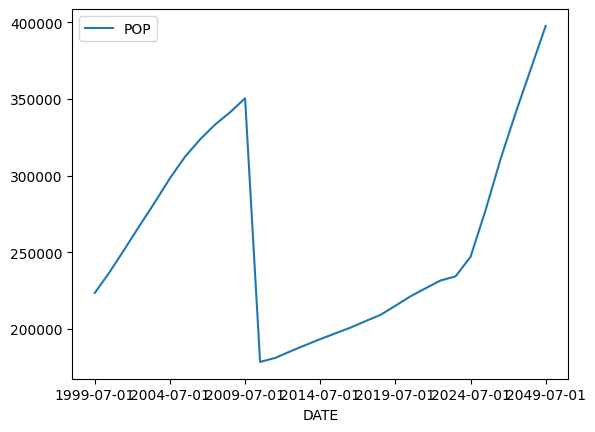

In [310]:
for geoid in ["39041"]:
    temp = insightsPop.loc[insightsPop["GEOID"] == geoid].copy()
    temp = temp.drop(columns="GEOID")
    #temp = temp.pivot(index="values="POP")
    temp.plot(x="DATE", y="POP")

In [311]:
temp

,POP,GEO_TYPE,DATE,VALUE_TYPE,SOURCE
1,223518,COUNTY,1999-07-01,ESTIMATE,CENINT
3,237292,COUNTY,2000-07-01,ESTIMATE,CENINT
5,252344,COUNTY,2001-07-01,ESTIMATE,CENINT
7,267684,COUNTY,2002-07-01,ESTIMATE,CENINT
9,282696,COUNTY,2003-07-01,ESTIMATE,CENINT
11,298306,COUNTY,2004-07-01,ESTIMATE,CENINT
13,312328,COUNTY,2005-07-01,ESTIMATE,CENINT
15,323592,COUNTY,2006-07-01,ESTIMATE,CENINT
17,333304,COUNTY,2007-07-01,ESTIMATE,CENINT
19,341352,COUNTY,2008-07-01,ESTIMATE,CENINT


## Export data

## Clean up

### Delete input data (maybe)

If PRESERVE_INPUT_DATA is not true, then delete the input data folder and all of its contents.

In [ ]:
if(PRESERVE_INPUT_DATA != True):
    shutil.rmtree(inputDir)
else:
    print("Preserving input data.")